In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Tue Nov 13 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [124]:
# %matplotlib inline
# %matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
EXTRA = ['age', 'sex', 'sc_bef', 'sc_aft']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-124-37fc0b3a2fbc>:29: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [202]:
meta_df['SEX'] = meta_df['SEX'].astype('category')
print("Women: %s " % len(meta_df['SEX'][meta_df['SEX']==0]))
print("Men: %s " % len(meta_df['SEX'][meta_df['SEX']==1]))
print("Age: \n%s" % meta_df['AGE'].describe())
print('250 Hz: %s \t 1000 Hz: %s' % (len(meta_df[meta_df['freq']==250]),len(meta_df[meta_df['freq']==1000])))

Women: 104 
Men: 29 
Age: 
count    133.000000
mean      47.706767
std        9.577263
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: AGE, dtype: float64
250 Hz: 99 	 1000 Hz: 34


In [114]:
def prepare_dfs(col='lyap'):
    df = pd.read_pickle(os.path.join(LABELED_ROOT, 'training.pickle'))
    df = df.loc[:, (slice(None), col)].dropna()
    df.columns = df.columns.droplevel(1)
    df = df.astype(float)
    
    df_y = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels.pickle'))
    df = df.join(df_y)
    
    extra = pd.DataFrame(index=df.index, columns=EXTRA)
    for name, row in extra.iterrows():
        extra.loc[name, 'age'] = meta_df.loc[int(name[0]), 'AGE']
        extra.loc[name, 'sex'] = meta_df.loc[int(name[0]), 'SEX']
        m1 = meta_df.loc[int(name[0]), 'M_1']
        m4 = meta_df.loc[int(name[0]), 'M_4']
        extra.loc[name, 'sc_bef'] = m1
        extra.loc[name, 'sc_aft'] = m4
        extra.loc[name, 'change'] = m1 / m4
    df = df.join(extra)
    
    df_bef = df.loc[(slice(None), 'a'), :]
    df_bef.index = df_bef.index.droplevel(1)
    df_aft = df.loc[(slice(None), 'b'), :]
    df_aft.index = df_aft.index.droplevel(1)
    
    in_both = df_bef.join(df_aft, how='inner', lsuffix='_l').index
    df = df.loc[(in_both, slice(None)), :]
    df_bef = df_bef.loc[in_both, :]
    df_aft = df_aft.loc[in_both, :]
     
    return df, df_bef, df_aft
df, df_bef, df_aft = prepare_dfs()
df

FP1       FP2        F3        F4        C3        C4  \
patient trial                                                               
1       a      0.035459  0.001366  0.075018  0.047399  0.045316  0.067459   
        b      0.039961  0.007670  0.004728  0.065995  0.038376  0.042247   
3       a      0.038618  0.038388  0.037981  0.038617  0.038788  0.039525   
        b      0.036502  0.037032  0.037891  0.038023  0.034823  0.037776   
4       a      0.037581  0.038454  0.052092  0.054974  0.052420  0.052925   
        b      0.036321  0.037169  0.050594  0.052020  0.048689  0.053127   
5       a      0.035184  0.034783  0.047611  0.047205  0.046589  0.050544   
        b      0.034452  0.034716  0.047076  0.045165  0.045319  0.046673   
7       a      0.052043  0.049147  0.051507  0.050472  0.052334  0.052027   
        b      0.055538  0.054386  0.056062  0.053363  0.054761  0.054099   
9       a      0.051195  0.050330  0.051464  0.050978  0.048068  0.049316   
        b      0.036028  0.052619  0.051382  0.035176  0.049184  0.050079   
10      a      0.065616  0.066336  0.064614  0.065398  0.040609  0.047962   
        b      0.045089  0.044546  0.043037  0.043522  0.043121  0.044721   
11      a      0.027414  0.020374  0.028592  0.035391  0.031482  0.035617   
        b      0.025749  0.027818  0.034706  0.025356  0.058315  0.031760   
12      a      0.008466  0.042049  0.021453  0.025497  0.028601  0.024391   
        b      0.031373  0.032909  0.041514  0.033519  0.014650  0.031264   
14      a      0.034126  0.002403  0.044667  0.048686  0.046408  0.046425   
        b      0.020946  0.025403  0.047615  0.047234  0.045588  0.047883   
15      a      0.032227  0.022277  0.042116  0.040636  0.040551  0.045107   
        b      0.020687  0.032564  0.029720  0.061335  0.039751  0.040346   
16      a      0.033016  0.034093  0.034990  0.034636  0.054840  0.034829   
        b      0.031404  0.033123  0.035711  0.034781  0.052794  0.052503   
17      a      0.064289  0.067604  0.064740  0.065250  0.061406  0.046417   
        b      0.043128  0.042158  0.042512  0.043822  0.049600  0.048150   
18      a      0.058628  0.058719  0.053867  0.060756  0.064429  0.058536   
        b      0.056592  0.057629  0.058199  0.055840  0.058439  0.058948   
19      a      0.051193  0.050885  0.052155  0.054767  0.054251  0.052663   
        b      0.037557  0.035665  0.051903  0.051030  0.053617  0.054668   
...                 ...       ...       ...       ...       ...       ...   
115     a      0.031472  0.013631  0.033166  0.032028  0.034326  0.050640   
        b      0.032986  0.032424  0.048750  0.050017  0.049673  0.049822   
116     a      0.031014  0.055874  0.039675  0.040085  0.059554  0.039828   
        b      0.022303  0.023513  0.041111  0.040262  0.036542  0.034106   
117     a      0.025589  0.042170  0.034803  0.033991  0.043832  0.049872   
        b      0.044087  0.038475  0.050169  0.049147  0.049713  0.049126   
119     a      0.035940  0.035151  0.050207  0.051606  0.048785  0.049763   
        b      0.028193  0.019048  0.034976  0.048608  0.049881  0.048194   
121     a      0.020256  0.018972  0.036157  0.036755  0.045972  0.037863   
        b      0.058467  0.024483  0.032374  0.035130  0.035498  0.036385   
122     a      0.027922  0.025826  0.023478  0.039281  0.037409  0.036443   
        b      0.026736  0.040042  0.035587  0.038816  0.038742  0.056204   
123     a      0.036014  0.038818  0.038678  0.039037  0.052840  0.039327   
        b      0.044784  0.033437  0.034347  0.058671  0.038092  0.041456   
124     a      0.047155  0.048498  0.048318  0.047533  0.050770  0.051264   
        b      0.042259  0.046078  0.043461  0.044242  0.046937  0.048834   
126     a      0.043505  0.024009  0.046247  0.043160  0.042294  0.062404   
        b      0.048939  0.034579  0.050558  0.052342  0.049378  0.051268   
127     a      0.031124  0.036301  0.046199  0.033330  0.031021  0.063042   
        b      0

In [175]:
print('Men / Women: {} / {}'.format(len(df[df['sex']==1]), len(df[df['sex']==0])))
age_desc = df['age'].describe()
print('Age summary: \n{}'.format(age_desc))
m1_desc = df['sc_bef'].describe()
print('Measurement 1: \n{}'.format(m1_desc))
m2_desc = df['sc_aft'].describe()
print('Measurement 2: \n{}'.format(m2_desc))

Men / Women: 55 / 185
Age summary: 
count    240.000000
mean      47.870833
std        9.718850
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: age, dtype: float64
Measurement 1: 
count    240.000000
mean      27.554167
std        4.200665
min       17.000000
25%       25.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: sc_bef, dtype: float64
Measurement 2: 
count    240.000000
mean      16.720833
std        7.880991
min        1.000000
25%       10.750000
50%       17.000000
75%       22.000000
max       37.000000
Name: sc_aft, dtype: float64


# Before and after comparison plots

<IPython.core.display.Javascript object>


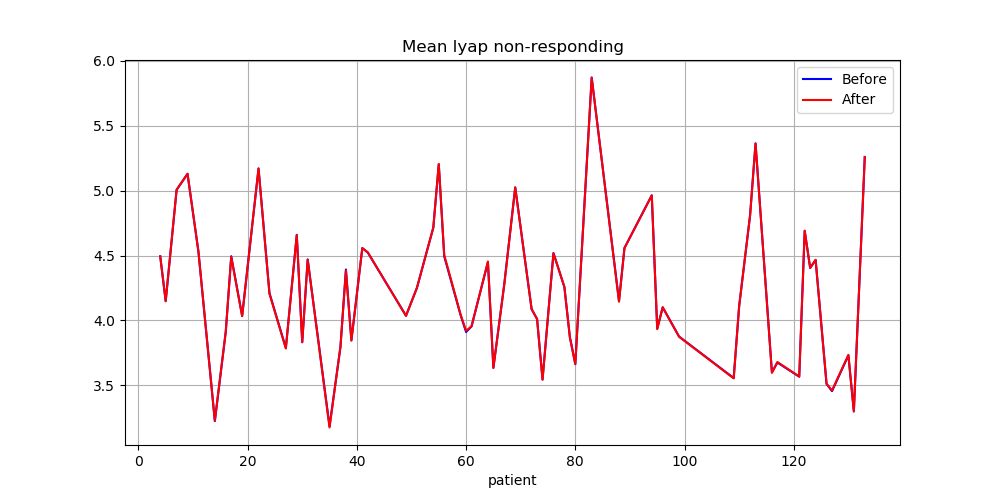

<IPython.core.display.Javascript object>


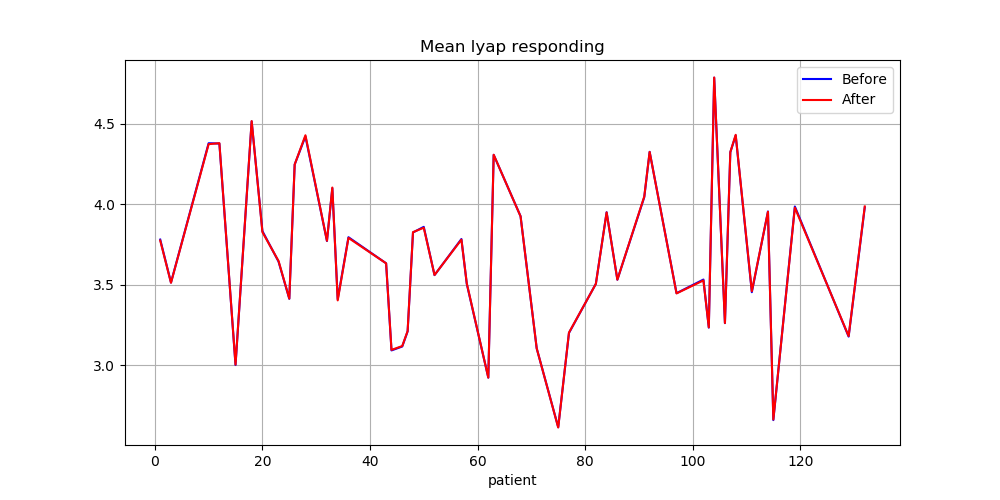

<IPython.core.display.Javascript object>


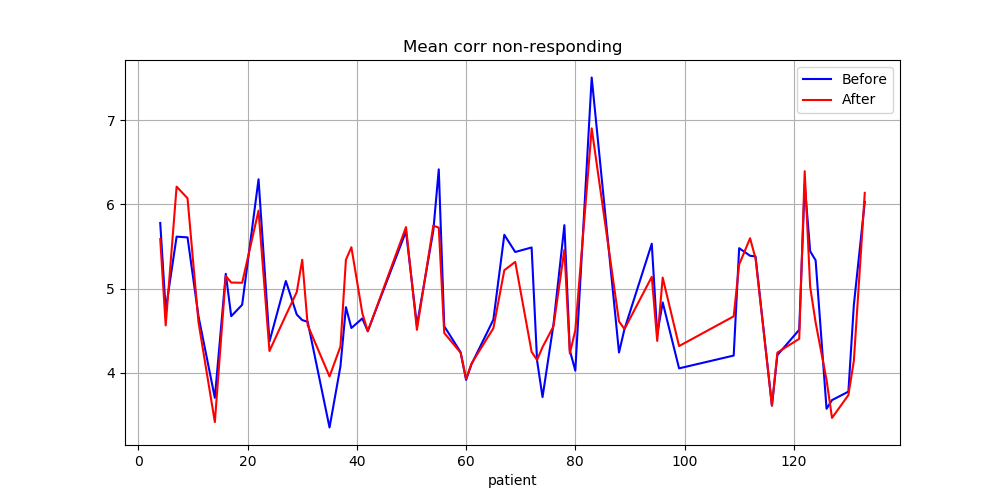

<IPython.core.display.Javascript object>


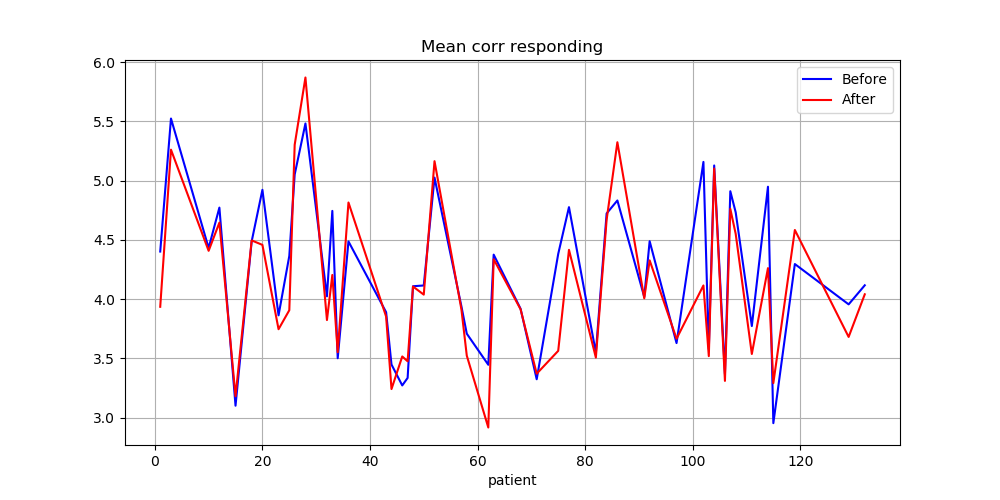

<IPython.core.display.Javascript object>


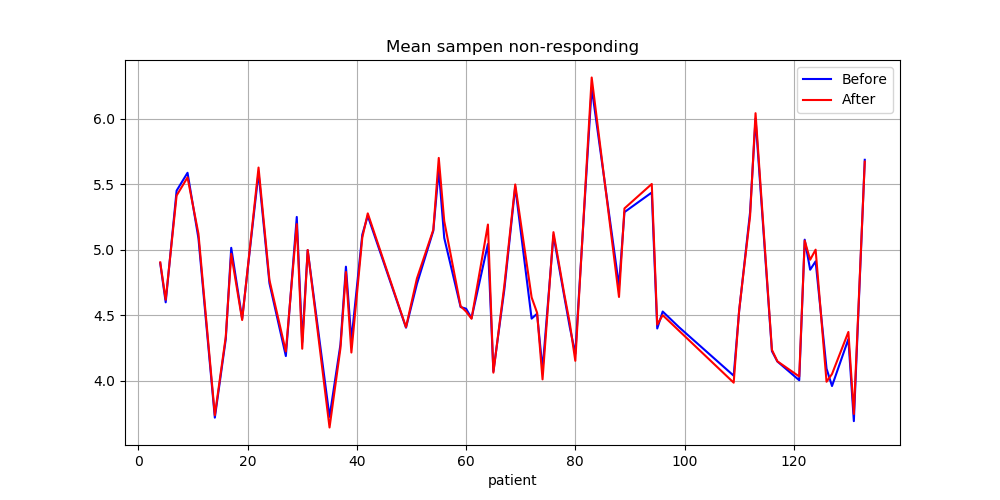

<IPython.core.display.Javascript object>


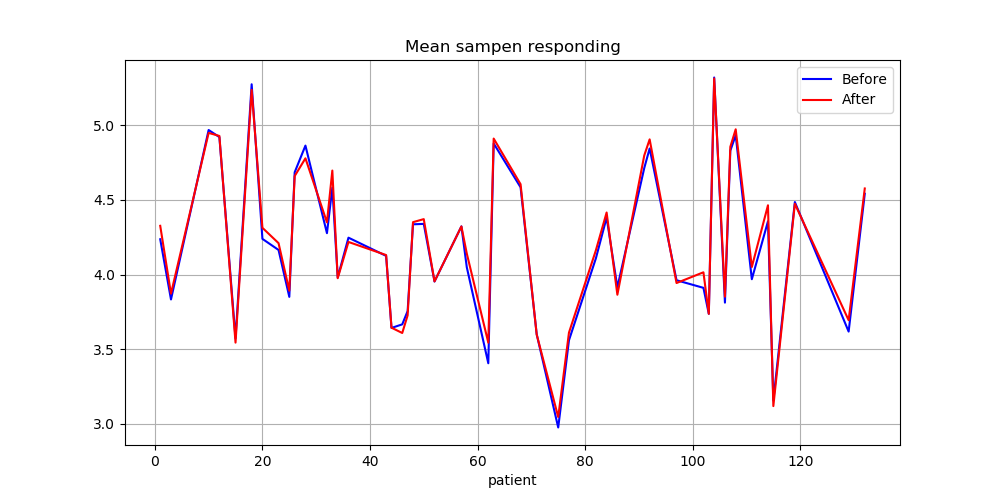

<IPython.core.display.Javascript object>


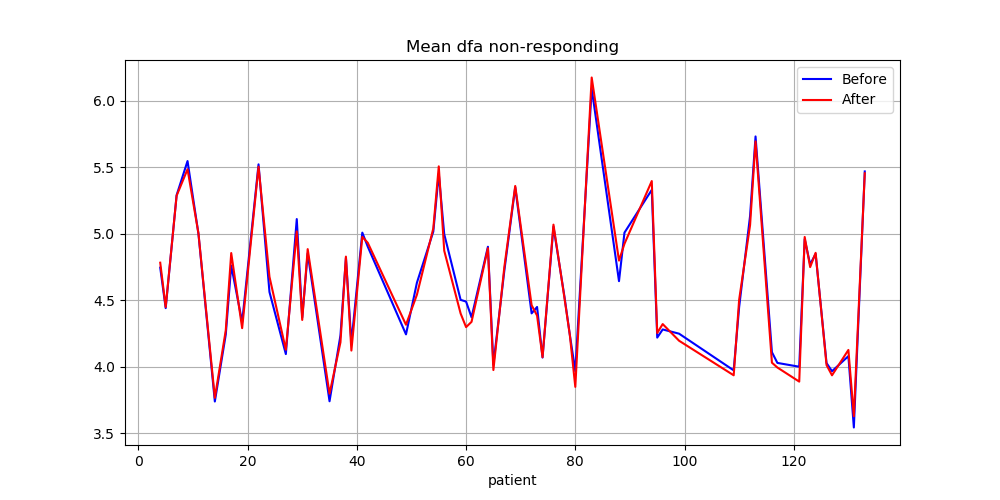

<IPython.core.display.Javascript object>


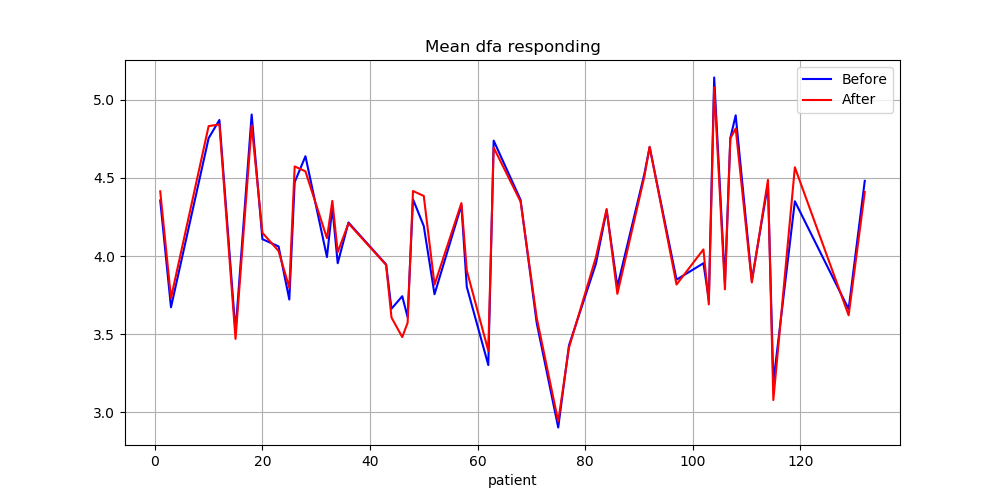

<IPython.core.display.Javascript object>


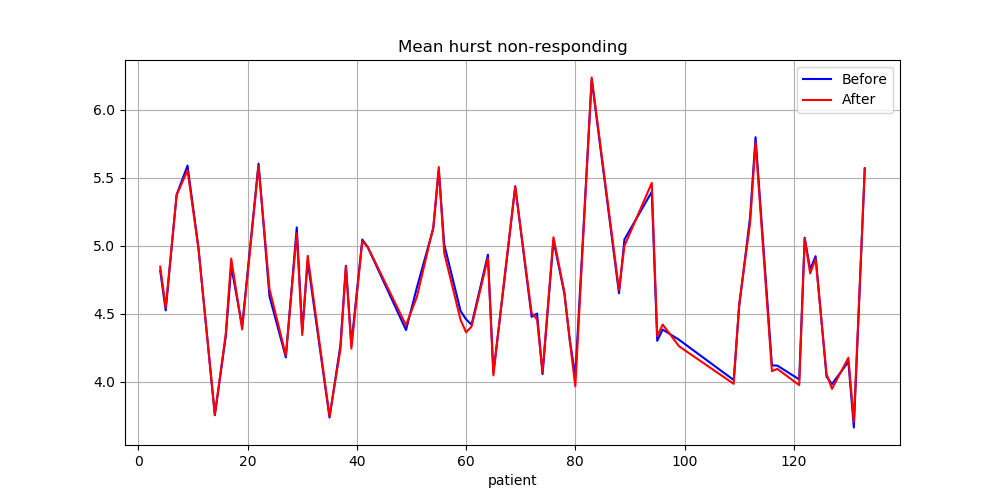

<IPython.core.display.Javascript object>


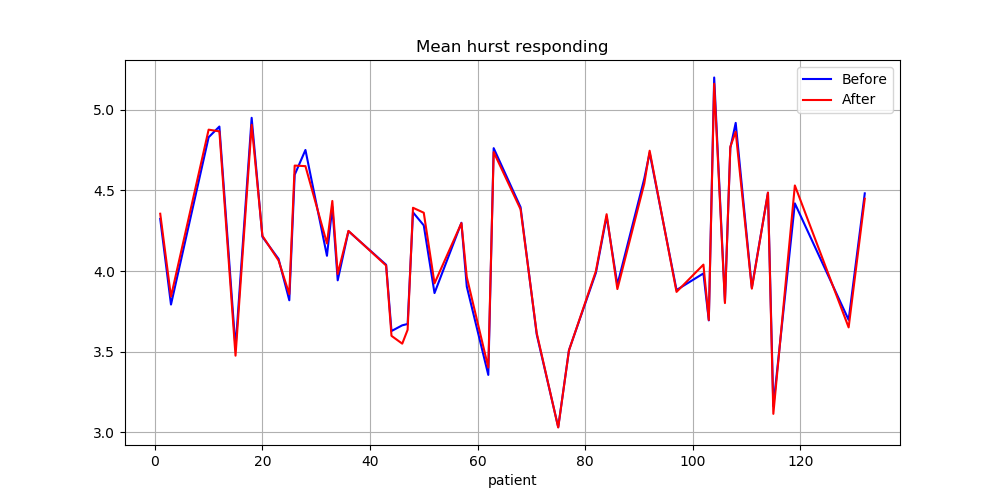

In [115]:
def plot_resp(df_bef, df_aft, m_name, resp):
    means_bef = df_bef[df_bef['label_r']==resp].mean(axis=1)
    means_aft = df_aft[df_aft['label_r']==resp].mean(axis=1)
    plt.figure(figsize=(10,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='Before')
    ax2 = means_aft.plot(color='red', grid=True, label='After')
    plt.legend()
    m = 'responding' if resp else 'non-responding'
    plt.title(f'Mean {m_name} {m}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}_{m}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name, 0)
    plot_resp(df_bef, df_aft, m_name, 1)

for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    plot_measure(df_bef, df_aft, col)

<IPython.core.display.Javascript object>


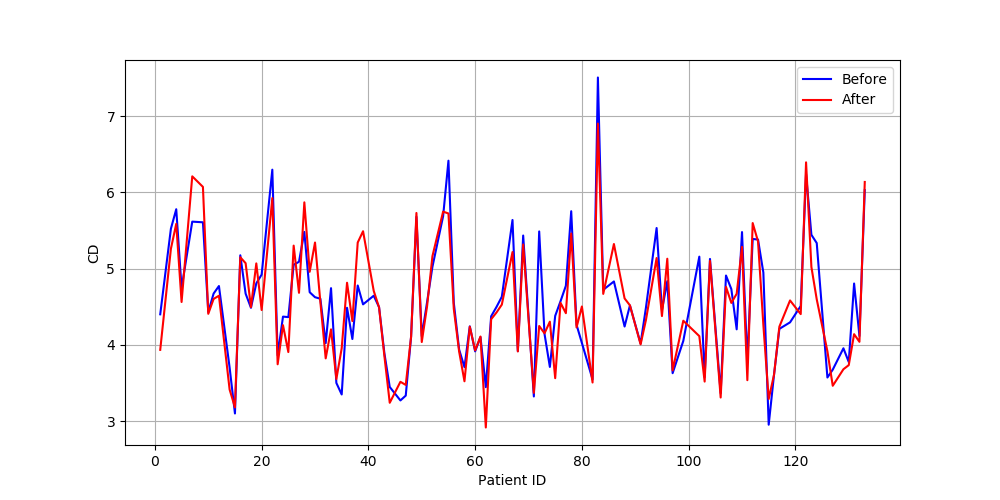

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


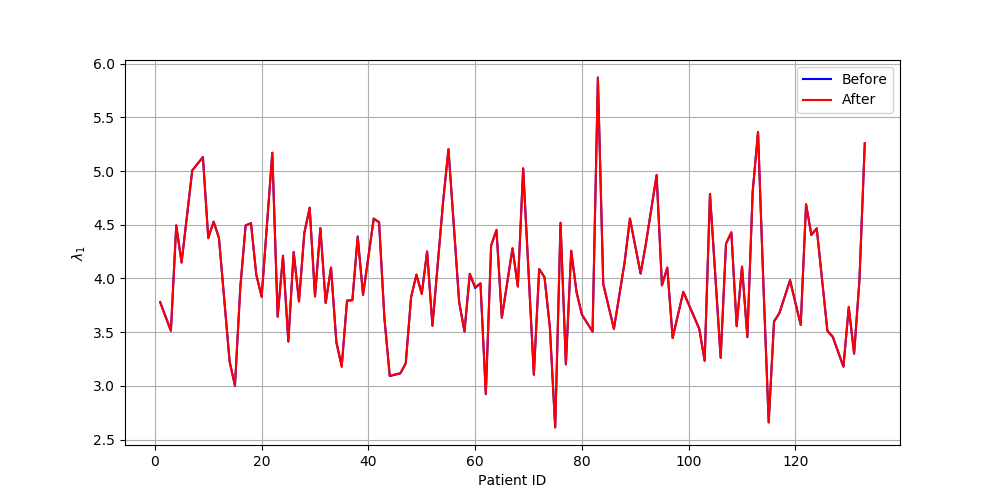

In [126]:
def plot_resp(df_bef, df_aft, m_name):
    means_bef = df_bef.mean(axis=1)
    means_aft = df_aft.mean(axis=1)
    plt.figure(figsize=(10,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='Before')
    ax2 = means_aft.plot(color='red', grid=True, label='After')
    plt.legend()
    # plt.title(f'Mean {m_name} all')
    plt.xlabel('Patient ID')
    plt.ylabel(f'{m_name}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name)

# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
#     df, df_bef, df_aft = prepare_dfs(col)
#     plot_measure(df_bef, df_aft, col)
df, df_bef, df_aft = prepare_dfs('corr')
plot_measure(df_bef, df_aft, 'CD')
df, df_bef, df_aft = prepare_dfs('lyap')
plot_measure(df_bef, df_aft, '$\lambda_1$')

# Before and after K-S test

In [185]:
from scipy.stats import ks_2samp

def print_res(name, res):
    if res.pvalue <= 0.02:
        m = '!!!'
    elif res.pvalue <= 0.05:
        m = '!!'
    elif res.pvalue < 0.08:
        m = '!'
    else:
        m = ''
    print('{}: \t {} \t {}'.format(name, res.pvalue, m))

def channel_wise_ks(df_bef, df_aft):
    print_res('Means', ks_2samp(df_bef.mean(axis=1), df_aft.mean(axis=1)))
    print_res('Stds', ks_2samp(df_bef.std(axis=1), df_aft.std(axis=1)))
    for col in df.loc[:, map(lambda c: not c.startswith('label'), df.columns)].columns:
        print_res(col, ks_2samp(df_bef[col], df_aft[col]))
        

for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    print('All')
    channel_wise_ks(df_bef, df_aft)
    print('\nNon-responding')
    channel_wise_ks(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0])
    print('\nResponding')
    channel_wise_ks(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1])
    print()

print('*** LOW / HIGH DEPRESSION SCORE***')
for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    low = df[df['label_d']=='L']
    high = df[df['label_d']=='H']
    channel_wise_ks(low, high)
    print()

LYAP
All
Means: 	 0.9999181744909945 	 
Stds: 	 0.9999998362267705 	 
FP1: 	 0.6737812270629111 	 
FP2: 	 0.8759546299464669 	 
F3: 	 0.286403832381986 	 
F4: 	 0.6737812270629111 	 
C3: 	 0.8759546299464663 	 
C4: 	 0.6737812270629111 	 
P3: 	 0.5637568068246708 	 
P4: 	 0.875954629946467 	 
O1: 	 0.2864038323819865 	 
O2: 	 0.4597384797051545 	 
F7: 	 0.9977494897329332 	 
F8: 	 0.56375680682467 	 
T3: 	 0.02087377655707352 	 !!
T4: 	 0.781593040441274 	 
T5: 	 0.6737812270629111 	 
T6: 	 0.45973847970515486 	 
Fz: 	 0.781593040441274 	 
Cz: 	 0.781593040441274 	 
Pz: 	 0.8759546299464663 	 
age: 	 1.0 	 
sex: 	 0.9999999999999996 	 
sc_bef: 	 0.9999999999998005 	 
sc_aft: 	 0.9999999999998005 	 

Non-responding
Means: 	 0.9999999795730488 	 
Stds: 	 0.9999999028739832 	 
FP1: 	 0.9985471906949807 	 
FP2: 	 0.388323114647915 	 
F3: 	 0.9038350101349778 	 
F4: 	 0.6182345315606481 	 
C3: 	 0.7376715063418823 	 
C4: 	 0.750593529821641 	 
P3: 	 0.18296605409672437 	 
P4: 	 0.9722357609

HURST
All
Means: 	 0.9977494897329332 	 
Stds: 	 0.9999181744909945 	 
FP1: 	 0.5637568068246692 	 
FP2: 	 0.08888451740883593 	 
F3: 	 0.5637568068246692 	 
F4: 	 0.5637568068246708 	 
C3: 	 0.06349967510656862 	 !
C4: 	 0.45973847970515425 	 
P3: 	 0.5637568068246708 	 
P4: 	 0.3665702007705864 	 
O1: 	 0.9841150390577886 	 
O2: 	 0.45973847970515425 	 
F7: 	 0.781593040441274 	 
F8: 	 0.5637568068246703 	 
T3: 	 0.2864038323819871 	 
T4: 	 0.21957157197261679 	 
T5: 	 0.5637568068246692 	 
T6: 	 0.5637568068246692 	 
Fz: 	 0.8759546299464673 	 
Cz: 	 0.2195715719726162 	 
Pz: 	 0.3665702007705852 	 
age: 	 1.0 	 
sex: 	 0.9999999999999996 	 
sc_bef: 	 0.9999999999998005 	 
sc_aft: 	 0.9999999999998005 	 

Non-responding
Means: 	 0.9999986966641958 	 
Stds: 	 0.9999354719765191 	 
FP1: 	 0.9384374936946982 	 
FP2: 	 0.2444714557465497 	 
F3: 	 0.45278721342603784 	 
F4: 	 0.7925200313737579 	 
C3: 	 0.044699493736527554 	 !!
C4: 	 0.7801552584457316 	 
P3: 	 0.7114841085503754 	 
P4:

# PCA

<IPython.core.display.Javascript object>


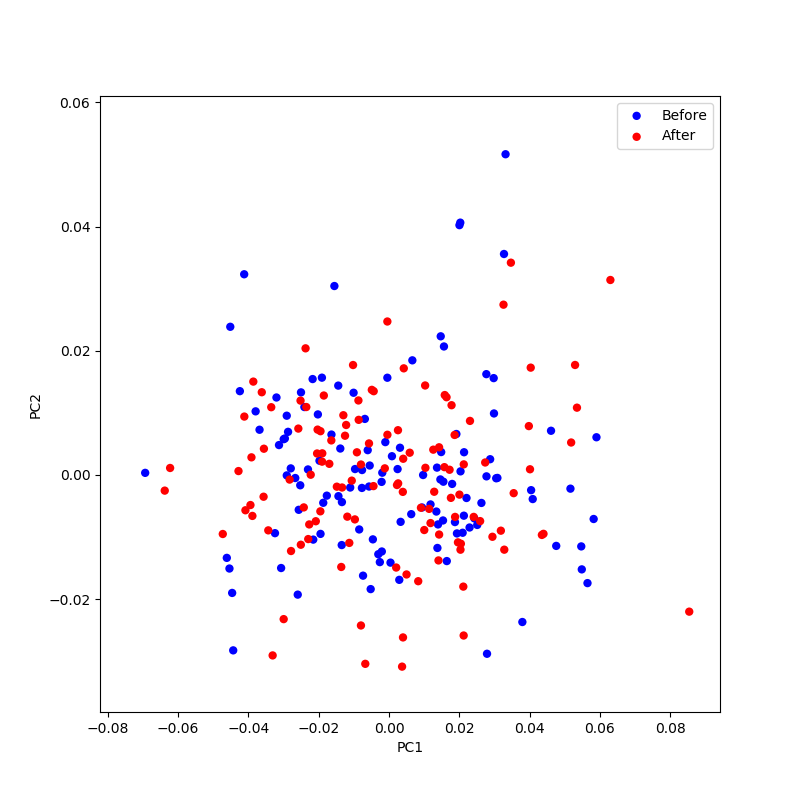

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

def plot_pca_2d(df_first, df_second, c1='blue', c2='red', title=""):
    pca = decomposition.PCA(n_components=2)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(first[:,0], first[:,1], c=c1, cmap='Blues', edgecolors='', label='Before')
    if second is not None:
        plt.scatter(second[:,0], second[:,1], c=c2, cmap='Reds', edgecolors='', label='After')
    # plt.title(title)
    plt.legend()
    # plt.colorbar()
    plt.show()

df, df_bef, df_aft = prepare_dfs('lyap')

plot_pca_2d(df_bef, df_aft, title="Before / After")
# plot_pca_2d(df, None, c1=df['change'], title="Change in score")
# plot_pca_2d(df_bef, None, c1=df_bef['sc_bef'], title="Change in score")

<IPython.core.display.Javascript object>


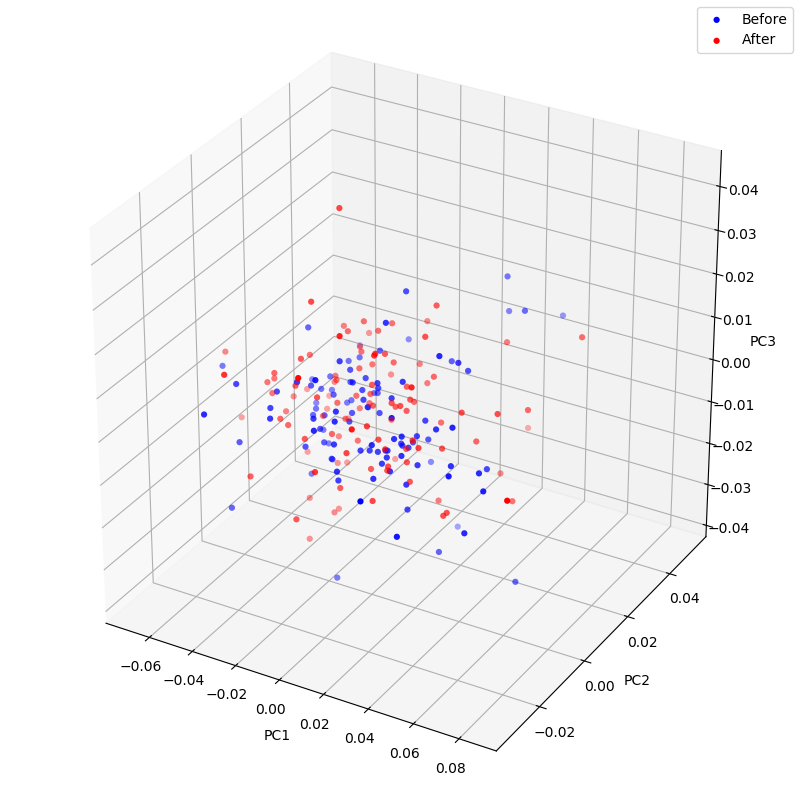

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


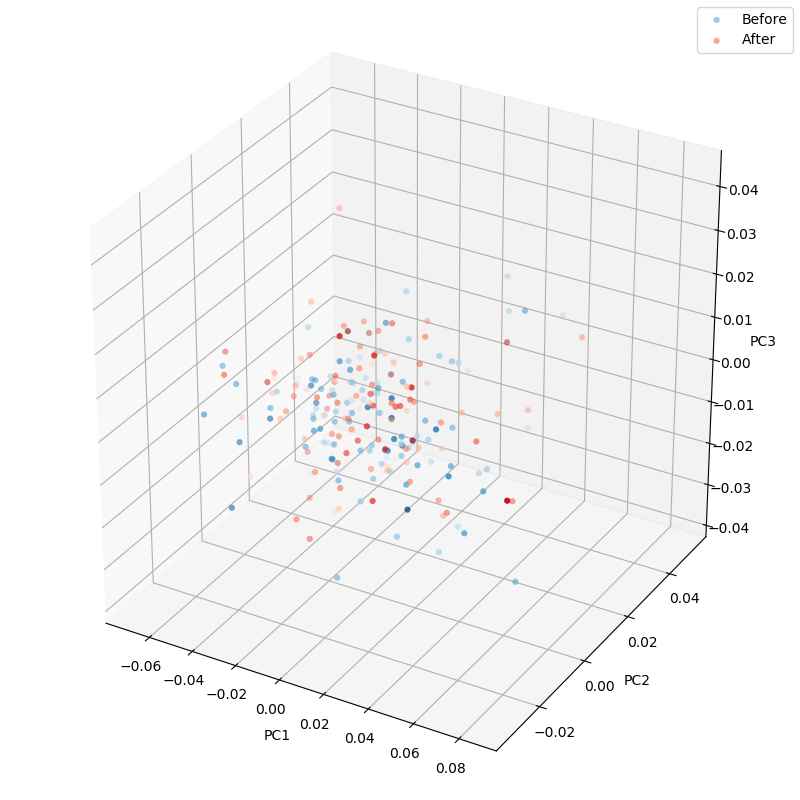

In [128]:
def plot_pca_3d(df_first, df_second=None, c1='blue', c2='red', title="", clus=False):
    pca = decomposition.PCA(n_components=3)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    if clus:
        clus_bef = df_first.iloc[(-4 < first[:,0]) & (first[:,0] < -2) & (first[:,1] < 1) & (0 < first[:,1]) & (abs(first[:,2]) < 1), :][EXTRA]
        clus_aft = df_second.iloc[(-4 < second[:,0]) & (second[:,0] < -2) & (second[:,1] < 1) & (0 < second[:,1]) & (abs(second[:,2]) < 1), :][EXTRA]
        overlap = clus_bef.join(clus_aft, how='inner', lsuffix='', rsuffix='_a')
        print(clus_bef)
        print(clus_aft)
        print(overlap.loc[:, ['age', 'sex', 'sc_bef', 'sc_aft']])
        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.scatter(first[:,0], first[:,1], first[:,2], c=c1, cmap='Blues', edgecolor='', label='Before')
    if second is not None:
        ax.scatter(second[:,0], second[:,1], second[:,2], c=c2, cmap='Reds', edgecolor='', label='After')
    # plt.title(title)
    plt.legend()
    plt.show()

df, df_bef, df_aft = prepare_dfs('lyap')

# plot_pca_3d(df_bef, df_aft, df_bef['age'], df_aft['age'])
plot_pca_3d(df_bef, df_aft, title="Before / After")
# plot_pca_3d(df[df['sex']==0], df[df['sex']==1], title="Men / Women") # Men corr cluster
plot_pca_3d(df_bef, df_aft, df_bef['sc_bef'], df_aft['sc_aft'], title="Scores bef / aft")

<IPython.core.display.Javascript object>


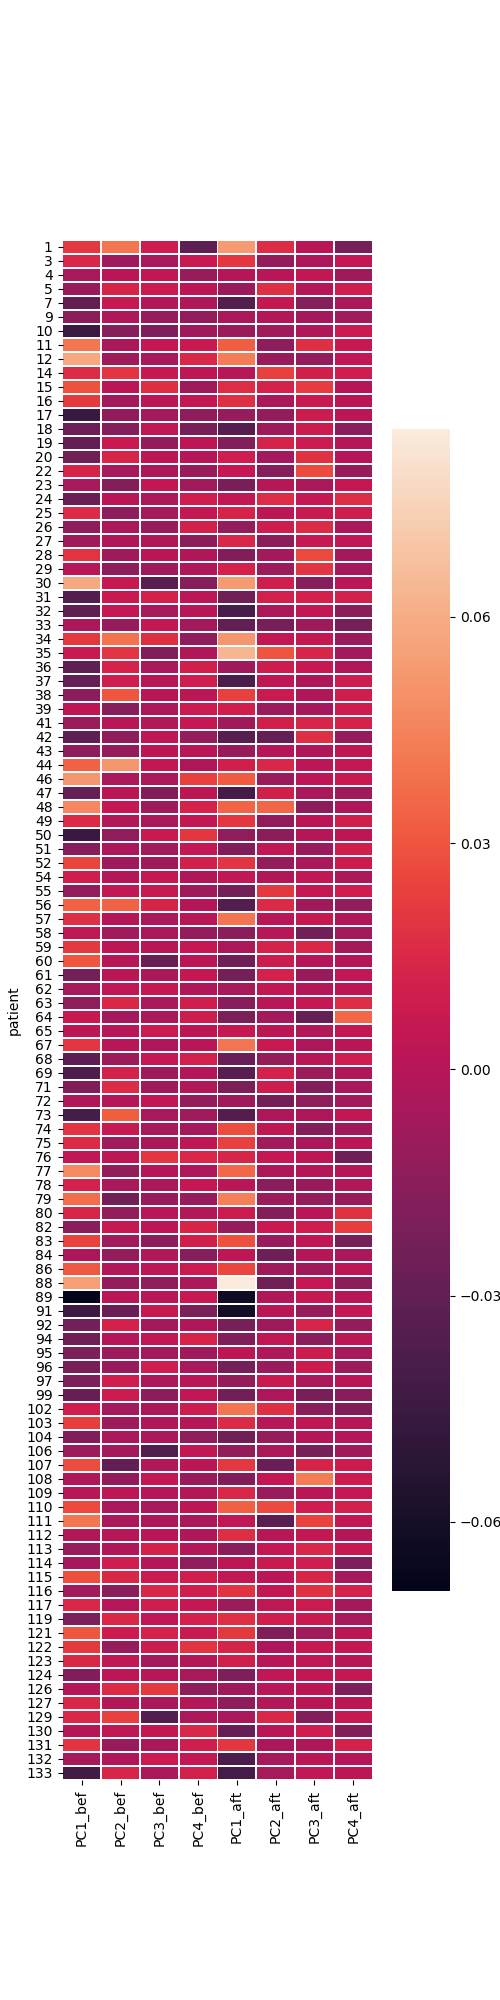

<IPython.core.display.Javascript object>


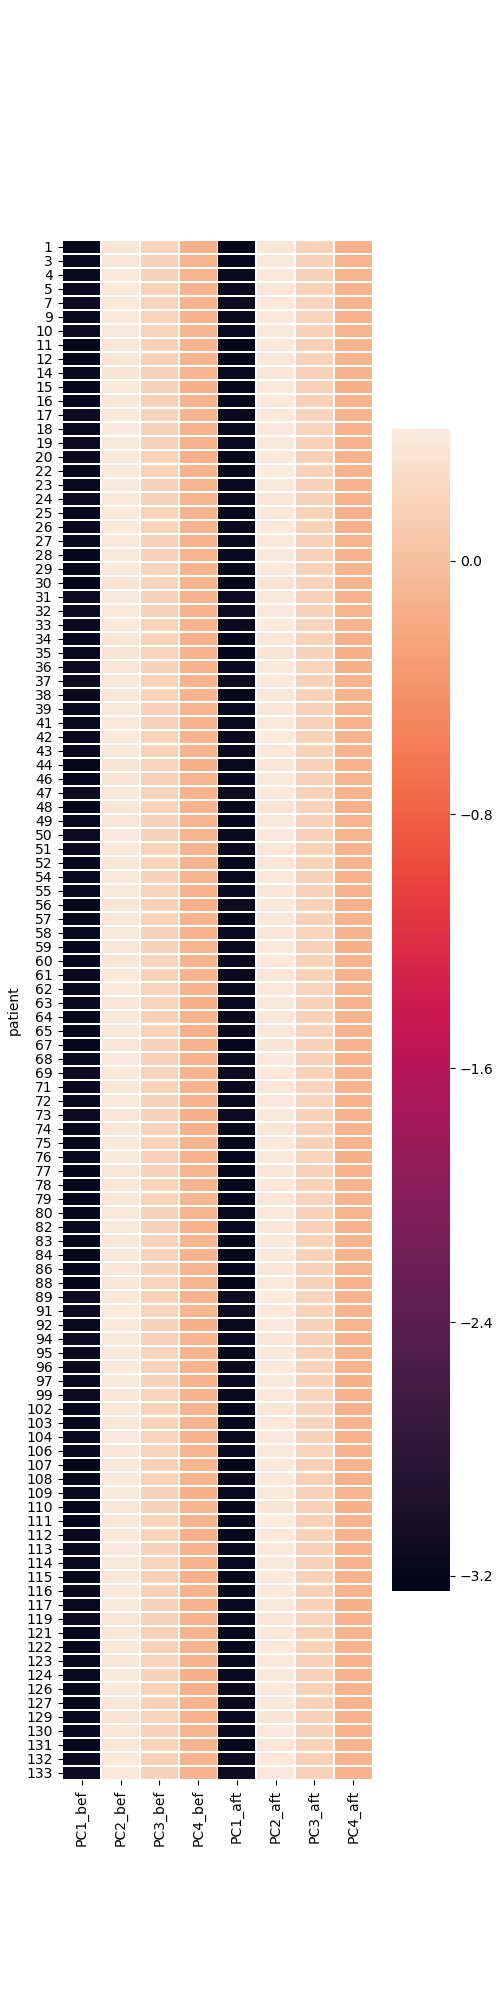

<IPython.core.display.Javascript object>


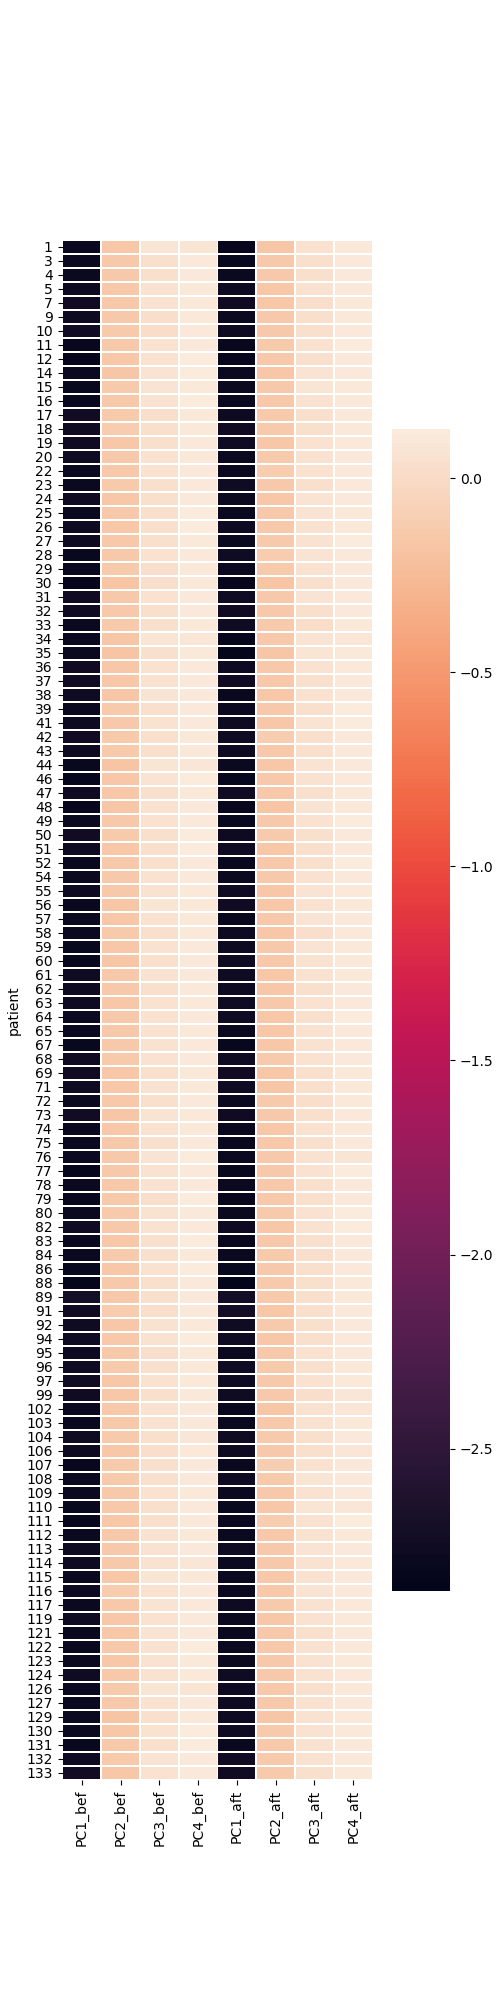

In [123]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

def plot_heatmap(df_bef=df_bef, df_aft=df_aft, n=3, title='All'):

    pca = decomposition.PCA(n_components=4)
    pca.fit(df[CHANNEL_NAMES])
    bef_proj_df = pd.DataFrame(pca.transform(df_bef[CHANNEL_NAMES]), index=df_bef.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    aft_proj_df = pd.DataFrame(pca.transform(df_aft[CHANNEL_NAMES]), index=df_aft.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])

    joined_df = bef_proj_df.join(aft_proj_df, lsuffix='_bef', rsuffix='_aft')

    plt.figure(figsize=(5, 20))
    ax = sns.heatmap(joined_df, linewidth=0.5)
    # plt.title(": ".join((measure, title)))
    plt.show()
    # plt.savefig(os.path.join(VISUAL_ROOT, "heatmaps", _".join((measure, title))+'.png'))

for measure in ('lyap', 'corr', 'sampen'):
    df, df_bef, df_aft = prepare_dfs(measure)
    plot_heatmap()
    # plot_heatmap(df_bef[df_bef['sex']==0], df_aft[df_aft['sex']==0], title='Women')
    # plot_heatmap(df_bef[df_bef['sex']==1], df_aft[df_aft['sex']==1], title='Men')
    # plot_heatmap(df_bef[df_bef['age']>50], df_aft[df_aft['age']>50], title='Age >= 50')
    # plot_heatmap(df_bef[df_bef['age']<=30], df_aft[df_aft['age']<=30], title='Age <= 30')
    # plot_heatmap(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1], title='Responding')
    # plot_heatmap(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0], title='Non-responding')
    # plot_heatmap(df_bef[df_bef['sc_bef']<25], df_aft[df_aft['sc_bef']<25], title='Score before < 25')
    # plot_heatmap(df_bef[df_bef['sc_bef']>=30], df_aft[df_aft['sc_bef']>=30], title='Score before >= 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']<25], df_aft[df_aft['sc_aft']<25], title='Score after < 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']>=30], df_aft[df_aft['sc_aft']>=30], title='Score after >= 25')
    

# Other ideas

<IPython.core.display.Javascript object>


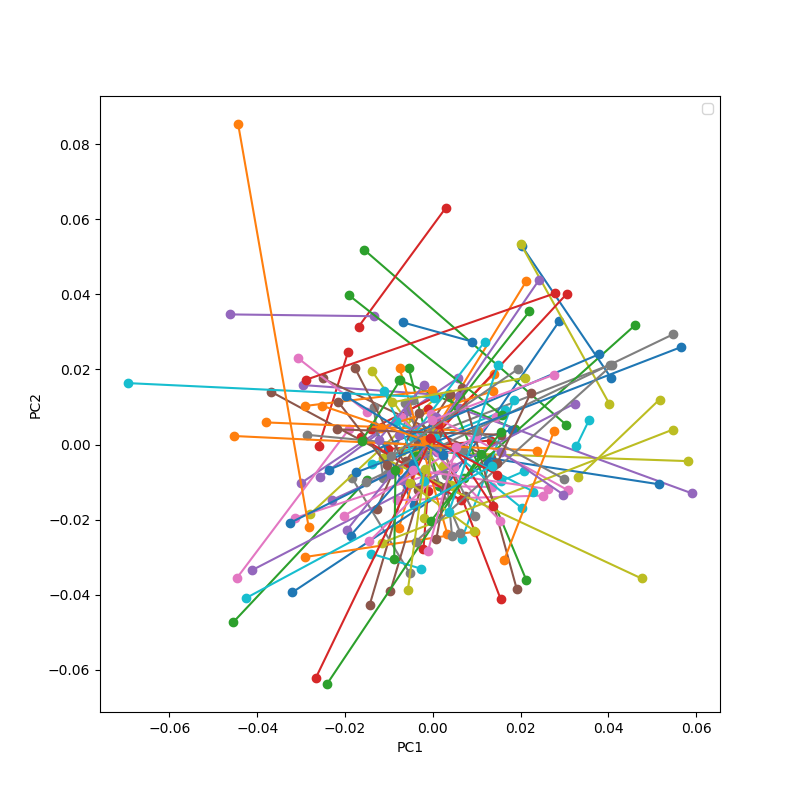

No handles with labels found to put in legend.


In [27]:
# Plot PCA, but same people with the same color

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def plot_pca_pairs_2d(df_first, df_second, title=""):
    pca = decomposition.PCA(n_components=2)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    for i in range(len(first)):
        plt.plot(first[i,:], second[i,:], 'o-')
        
    plt.title(title)
    plt.legend()
    plt.show()

df, df_bef, df_aft = prepare_dfs('lyap')

plot_pca_pairs_2d(df_bef, df_aft, title="")

In [65]:
# For each person, plot their distance between before / after
from math import sqrt

def filter_by_distance(df_first, df_second, n_components=3):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    dists = []
    for fr, sr in zip(first, second):
        dists.append(sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)])))
    perc = np.percentile(dists, 90)
    df = pd.DataFrame()
    for i, (fr, sr) in enumerate(zip(first, second)):
        dist = sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)]))
        if dist > perc:
            df = df.append(df_first.iloc[i, :]) 
    print(df.loc[:, ['label_r', 'age', 'sex', 'sc_bef', 'sc_aft', 'change']])
    

df, df_bef, df_aft = prepare_dfs('lyap')

filter_by_distance(df_bef, df_aft)

     label_r   age  sex  sc_bef  sc_aft     change
12       1.0  59.0  1.0    30.0    12.0   2.500000
30       0.0  37.0  0.0    31.0    22.0   1.409091
38       0.0  55.0  0.0    29.0    19.0   1.526316
39       0.0  51.0  1.0    23.0    15.0   1.533333
46       1.0  37.0  0.0    24.0    11.0   2.181818
50       1.0  48.0  1.0    29.0    11.0   2.636364
71       1.0  41.0  0.0    23.0     5.0   4.600000
74       0.0  38.0  0.0    26.0    19.0   1.368421
77       1.0  31.0  0.0    32.0    10.0   3.200000
89       0.0  52.0  0.0    31.0    24.0   1.291667
91       1.0  51.0  0.0    29.0    14.0   2.071429
105      1.0  46.0  0.0    30.0     1.0  30.000000
